<a href="https://colab.research.google.com/github/Akash-bits/Quora-Question-Pair-Similarity/blob/main/basicPlusW2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akashreddy0608","key":"336887cb4e220ac51bf780a850499553"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c quora-question-pairs

100% 308M/309M [00:02<00:00, 137MB/s]
100% 309M/309M [00:02<00:00, 110MB/s]


In [8]:
!unzip quora-question-pairs.zip

Archive:  quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [9]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [10]:
!pip install distance
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 180 kB 5.0 MB/s 
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16276 sha256=c4b2d93eaef43c1b397467e48e05b55b89282233ec88ce384068f093e636cd5e
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


In [11]:
df=pd.read_csv("train.csv")
df.shape

(404290, 6)

In [12]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In the dataset we have 404290 rows / data points and 6 columns / features. 
Of the 404290 data points 2 have question2 as null and 1 has question1 null. We can handle them by completely removing those rows or replacing the null values with empty string.
 

Number of unique questions =  537933 

Number of repeating questions =  111780 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



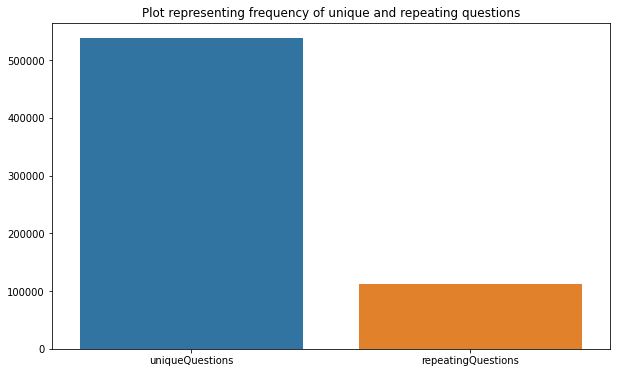

In [14]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unqQids = np. unique(qids)
print('Number of unique questions = ',len(unqQids),"\n")
qidsGrt1=np.sum(qids.value_counts()>1)
print('Number of repeating questions = ',qidsGrt1,"\n")

x = ["uniqueQuestions" , "repeatingQuestions"]
y =  [len(unqQids) , qidsGrt1]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing frequency of unique and repeating questions")
sns.barplot(x,y)
plt.show()

Now lets see if we have a uniform dataset by finding the counts of is_duplicate =0 and =1.
We find that the non-duplicates constitute 63.08% while the duplicates constitute 36.92% of the data points. 

In [15]:
print('rows with is_duplicate = 0 : ',(100 - round(df['is_duplicate'].mean()*100, 2)),'%\n')
print('rows with is_duplicate = 1 : ',(round(df['is_duplicate'].mean()*100, 2)),"%\n")

rows with is_duplicate = 0 :  63.08 %

rows with is_duplicate = 1 :  36.92 %



Now lets deal with NaN values. Since we have NaN only under question1 and question2, I am making them empty strings, instead of removing the row. 

In [16]:
nullRows = df[df.isnull().any(1)] 
print(nullRows)
#df=df.fillna(' ')
df = df.dropna(how="any").reset_index(drop=True)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


**Text PreProcessing**<br>
Here i expand word contractions, replace certain special symbols with specific strings , remove punctuations and html tags.

In [17]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # replacing certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    #expanding contractipns
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [18]:
df['question1']=df['question1'].apply(preprocess)
df['question2']=df['question2'].apply(preprocess)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning:

"b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.



**Basic Features** <br>
q1len : number of chars in q1 <br>
q2len : number of chars in q2 <br>
q1wc : number of words in q1 <br>
q2wc : number of words in q2 <br>
commonwc : number of words common between q1 and q2 <br>
cwcRatio : (commonwc) / (number of unique words in question1 + question2) <br>

In [19]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
#df['q1wc'] = df['question1'].str.split(" ").len()
#df['q2wc'] = df['question2'].str.split(" ").len()
df['q1wc'] = df['question1'].apply(lambda x: len(x.split(" ")))
df['q2wc'] = df['question2'].apply(lambda x: len(x.split(" ")))

In [20]:
def commonWordCount(row):
  wordsIn1=set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  wordsIn2=set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return len(wordsIn1 & wordsIn2)

df['commonwc'] = df.apply(commonWordCount, axis=1)

In [21]:
def cwcratio(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['cwcRatio'] = df.apply(cwcratio, axis=1)

In [22]:
df

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,0.478261
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,8,0.307692
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,0.166667
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,0,49,64,12,18,1,0.045455
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,4,0.190476
...,...,...,...,...,...,...,...,...,...,...,...,...
404282,404285,433578,379845,how many keywords are there in the racket prog...,how many keywords are there in perl programmin...,0,84,78,14,13,11,0.440000
404283,404286,18840,155606,do you believe there is life after death,is it true that there is life after death,1,40,41,8,9,5,0.312500
404284,404287,537928,537929,what is one coin,what is this coin,0,16,17,4,4,3,0.375000
404285,404288,537930,537931,what is the approx annual cost of living while...,i am having little hairfall problem but i want...,0,93,126,18,27,2,0.047619


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



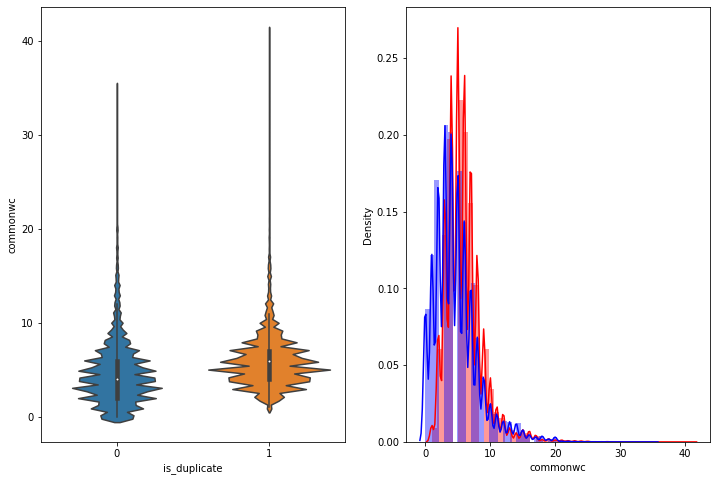

In [23]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'commonwc', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['commonwc'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['commonwc'][0:] , label = "0" , color = 'blue' )
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



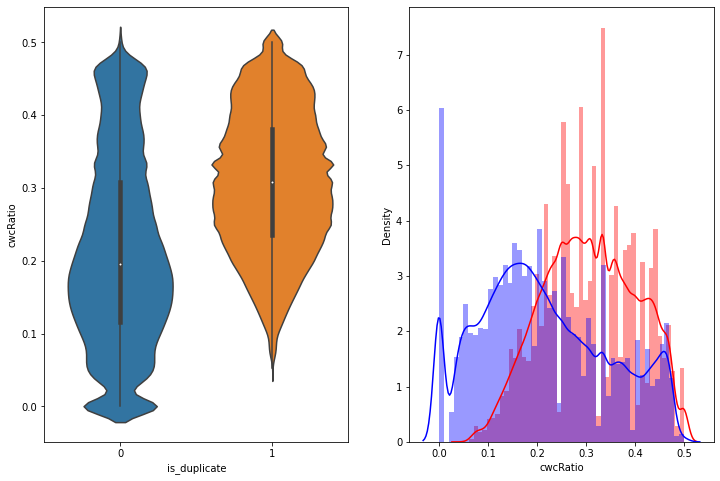

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'cwcRatio', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['cwcRatio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['cwcRatio'][0:] , label = "0" , color = 'blue' )
plt.show()

There is more overlap in case of "common word count" , compared to cwcRatio. However both the plots have few regions that can be classified without ambiguity.

**NLP Featues** <br>
Let us add a few more features which will help us maintain the semantics of the questions. For this i am using TF-IDF weighted word 2 vec. Then for each question to get the vector glove is used.

In [25]:
import spacy
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
#encoding to unicode

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#get list of all questions
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [27]:
!python -m spacy download en_core_web_lg
!python -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400.7 MB 6.1 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [28]:
from tqdm import tqdm


In [29]:
nlp = spacy.load('en_core_web_lg')
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progrss bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 300])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

  1%|          | 3302/404287 [00:32<1:00:55, 109.68it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning:

invalid value encountered in true_divide

100%|██████████| 404287/404287 [1:02:43<00:00, 107.41it/s]


In [32]:
df.head

<bound method NDFrame.head of             id    qid1    qid2  \
0            0       1       2   
1            1       3       4   
2            2       5       6   
3            3       7       8   
4            4       9      10   
...        ...     ...     ...   
404282  404285  433578  379845   
404283  404286   18840  155606   
404284  404287  537928  537929   
404285  404288  537930  537931   
404286  404289  537932  537933   

                                                question1  \
0       what is the step by step guide to invest in sh...   
1       what is the story of kohinoor  koh i noor  dia...   
2       how can i increase the speed of my internet co...   
3       why am i mentally very lonely  how can i solve it   
4       which one dissolve in water quikly sugar  salt...   
...                                                   ...   
404282  how many keywords are there in the racket prog...   
404283           do you believe there is life after death   
404284      

In [33]:
df.to_csv('basicPlusGlove.csv')

In [36]:
files.download('basicPlusGlove.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
vecs2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progrss bar
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    # 384 is the number of dimensions of vectors 
    mean_vec2 = np.zeros([len(doc2), 300])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

  5%|▍         | 20070/404287 [03:16<1:06:14, 96.68it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning:

invalid value encountered in true_divide

100%|██████████| 404287/404287 [1:04:10<00:00, 105.01it/s]


In [35]:
df.to_csv('basicPlusGlove.csv')

In [37]:
df.shape

(404287, 14)

In [39]:
#copying csv file into drive
import shutil
colab_link = "/content/basicPlusGlove.csv"
gdrive_link = "/content/drive/MyDrive/Quora Question Pair Similarity/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/Quora Question Pair Similarity/basicPlusGlove.csv'

In [41]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio,q1_feats_m,q2_feats_m
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,0.478261,"[-3.2682181298732758, 16.10115161538124, 3.013...","[0.39372511208057404, 13.772704988718033, -0.4..."
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,8,0.307692,"[9.672016978263855, 12.216672867536545, 18.288...","[4.6806506514549255, 9.614736139774323, 20.218..."
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,0.166667,"[1.1439417898654938, 15.838146537542343, -7.83...","[-16.655207440257072, 17.12328747753054, -8.70..."
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,0,49,64,12,18,1,0.045455,"[-4.816182664595544, 16.469067811965942, -15.2...","[-1.068600445985794, 33.550283312797546, 24.73..."
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,15,7,4,0.190476,"[-11.158063665032387, 19.905150055885315, -4.7...","[-5.422468423843384, 1.7065531015396118, 1.800..."


In [42]:
df1 = df.drop(['qid1','qid2','question1','question2'],axis=1)

In [45]:
df1_q1 = pd.DataFrame(df1.q1_feats_m.values.tolist(), index = df1.index)
df1_q2 = pd.DataFrame(df1.q2_feats_m.values.tolist(), index = df1.index)

In [46]:
df1_q1['id'] = df1['id']
df1_q2['id'] = df1['id']
df1 = df1.merge(df1_q1, on='id',how='left')
df1 = df1.merge(df1_q2, on='id', how='left')
df1.head()

,id,is_duplicate,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio,q1_feats_m,q2_feats_m,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,65,56,14,12,11,0.478261,"[-3.2682181298732758, 16.10115161538124, 3.013...","[0.39372511208057404, 13.772704988718033, -0.4...",...,-17.746422,7.232092,1.579207,-7.446900,0.359304,-11.831150,-11.248358,1.850926,3.630057,11.941713
1,1,0,50,87,12,17,8,0.307692,"[9.672016978263855, 12.216672867536545, 18.288...","[4.6806506514549255, 9.614736139774323, 20.218...",...,22.831051,3.331700,-5.067793,6.977135,33.759664,6.036938,-27.212781,13.088900,-4.930414,33.397953
2,2,0,72,58,14,10,4,0.166667,"[1.1439417898654938, 15.838146537542343, -7.83...","[-16.655207440257072, 17.12328747753054, -8.70...",...,-23.374570,-1.189946,11.905316,9.455848,10.873571,1.089241,6.160880,0.308965,-12.052598,26.728497
3,3,0,49,64,12,18,1,0.045455,"[-4.816182664595544, 16.469067811965942, -15.2...","[-1.068600445985794, 33.550283312797546, 24.73...",...,13.241012,-3.984124,-11.720555,12.137378,-9.193972,-21.155019,-7.105915,-19.470968,2.164063,2.874752
4,4,0,75,38,15,7,4,0.190476,"[-11.158063665032387, 19.905150055885315, -4.7...","[-5.422468423843384, 1.7065531015396118, 1.800...",...,-10.250352,-8.426056,-14.438814,-12.661690,-4.410530,12.533723,-11.635175,-16.318996,3.555606,-9.794859


In [48]:
df1.to_csv('Features1.csv')
colab_link = "/content/Features1.csv"
gdrive_link = "/content/drive/MyDrive/Quora Question Pair Similarity/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/Quora Question Pair Similarity/Features1.csv'

**Machine Learning Models**<br>



In [ ]:
# i = []
# while(True):
#     i.append('a')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import warnings
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [3]:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [5]:
# link = 'https://drive.google.com/file/d/1-ADVYYHxJtzBGNOlkvP4xUXLR2ccLMrT/view?usp=sharing'
# fluff, id = link.split('=')
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('Features1.csv')  
# df3 = pd.read_csv('Features1.csv')

ApiRequestError: ignored

In [2]:
df = pd.read_csv('Features1.csv')

In [3]:
df = df.sample(frac=0.4)
df = df.dropna()

In [4]:
y_data = df['is_duplicate']
df.drop(['id','is_duplicate'], axis=1, inplace=True)

In [5]:
y_data

151658    0
359564    1
126079    1
57102     0
163247    0
         ..
78024     0
217986    0
283901    0
380535    0
168452    1
Name: is_duplicate, Length: 161710, dtype: int64

In [6]:
df.head()

,Unnamed: 0,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio,q1_feats_m,q2_feats_m,0_x,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
151658,151658,114,47,28,10,3,0.103448,[ 3.48043011e+01 5.41886816e+01 -1.13607748e+...,[ 1.74141659e+01 1.92543378e+00 1.16691386e+...,34.804301,...,-1.308354,-5.071345,7.093942,-13.635112,2.155929,-4.600517,-23.281276,8.640581,-5.180086,17.164042
359564,359564,50,59,10,12,7,0.318182,[-4.37073544e-01 6.20409839e+00 -7.70219269e+...,[-7.60694847e-01 4.94117364e-01 -7.50013226e+...,-0.437074,...,-16.236602,-0.254579,3.618814,-1.438708,5.354496,0.755384,-9.866916,0.277274,4.801539,5.027355
126079,126079,83,85,17,18,14,0.482759,[ 2.99731511e+01 1.17447369e+01 -1.57933464e+...,[ 2.99731511e+01 1.17447369e+01 -1.57933464e+...,29.973151,...,6.271350,-4.613512,6.464467,-7.804681,14.729561,4.907862,-20.297725,8.775198,13.673719,5.453899
57102,57102,33,62,7,12,4,0.235294,[ 9.37335148e-01 -3.54977274e+00 -3.39532283e+...,[-1.33143850e+00 3.86624439e+00 -8.22738922e+...,0.937335,...,-5.198283,-4.678459,-3.009895,-13.943479,1.499906,10.490951,-10.394419,3.189077,-14.461114,1.039727
163247,163247,58,56,9,9,8,0.444444,[ 8.22692004e+00 3.97625268e-01 1.25873789e+...,[ 2.73506835e+00 -3.19299443e+00 8.61105196e+...,8.226920,...,-11.528975,-8.578866,21.885580,10.144494,-11.615549,2.255428,5.096182,7.507326,-5.440984,12.156663


In [7]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
df.drop(['q1_feats_m','q2_feats_m'],axis=1,inplace=True)

In [9]:
#x_train, x_test, y_train, y_test = train_test_split(df, y_data)
x_train,x_test, y_train, y_test = train_test_split(df, y_data, stratify=y_data, test_size=0.3)

In [11]:
#del df

In [10]:
len(np.where(np.isnan(x_test)))

2

In [12]:
logisticRegr = LogisticRegression()

In [13]:
logisticRegr.fit(x_train, y_train)

LogisticRegression()

In [14]:
accur = logisticRegr.score(x_test, y_test)
print(accur)

0.7218065260857914


In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [16]:
rf.fit(x_train,y_train)

RandomForestClassifier()

In [17]:
y_pred = rf.predict(x_test)
accuracy_score(y_test,y_pred)

0.7771112897573846

In [18]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [20]:
xgb.fit(x_train,y_train)


XGBClassifier()

In [21]:
y_pred = xgb.predict(x_test)
accuracy_score(y_test,y_pred)

0.7346484447467689

I took 40% of the dataset size (due to limitations of computation power) and trained and tested on logarithmic regression, random forest and xgboost - they gave accuracies of 72.18%, 77.71% and 73.46% respectively.